In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model, standardize_dataset
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

In [18]:
def mirror_conn(matrix, region_indices, vecrorize_mat = True):
    """
    Flips the connectivity of specified regions within their hemispheres. Handles both single indices and lists of indices.
    
    :param matrix: The connectivity matrix.
    :param region_indices: A single index or a list of indices for the regions.
    :return: A 3D array of modified connectivity matrices. Each "slice" corresponds to the matrix after flipping each specified region.
    """
    # Ensure region_indices is a list to simplify processing
    if not isinstance(region_indices, list):
        region_indices = [region_indices]
    
    flipped_matrices = []
    
    for index in region_indices:
        new_matrix = matrix.copy()
        hemisphere_size = matrix.shape[0] // 2
        is_left_hemisphere = index < hemisphere_size
        opposite_index = index + (-1 if is_left_hemisphere else 1) * hemisphere_size

        # Flip connectivity for the specified region within its hemisphere
        if is_left_hemisphere:
            new_matrix[index, :hemisphere_size], new_matrix[opposite_index, :hemisphere_size] = \
                new_matrix[opposite_index, :hemisphere_size].copy(), new_matrix[index, :hemisphere_size].copy()
        else:
            new_matrix[index, hemisphere_size:], new_matrix[opposite_index, hemisphere_size:] = \
                new_matrix[opposite_index, hemisphere_size:].copy(), new_matrix[index, hemisphere_size:].copy()
            
        if vecrorize_mat:
            new_matrix = sym_matrix_to_vec(new_matrix, discard_diagonal = True)
        flipped_matrices.append(new_matrix)
        
    return np.array(flipped_matrices)

In [55]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, region_indices = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)
        targets = pd.read_csv(path_target)[target_name].values
        

        # Split the dataset into training and test sets
        train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if train:
            # augmentation only in training mode
            augmented_features = np.array([self.transform(sample, region_indices = region_indices) for sample in features])
            print(augmented_features.shape)

            self.n_views = self.n_views + augmented_features.shape[1]
            print(augmented_features.shape[0] == self.n_sub)
            self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
            print(self.features.shape)
            for sub in range(self.n_sub):
                self.features[sub, 0, :] = vectorized_feat[sub]
                self.features[sub, 1:, :] = augmented_features[sub]
        else:
            self.features = vectorized_feat
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets
    

In [56]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

In [57]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [58]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
dataset = MatData("matrices.npy", "participants.csv", 'age', transform = mirror_conn, region_indices = [1, 2, 3, 4])

(748, 4, 499500)
True
(748, 5, 499500)


In [6]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [7]:
train_dataset.dataset.features.shape

(147, 499500)

In [8]:
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, krnl_sigma = None, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.delta_reduction = delta_reduction
        self.krnl_sigma = krnl_sigma

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction}, ' \
               f'krnl_sigma={self.krnl_sigma}'
                

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        n_views = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            # labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError(f'Num of labels does not match num of features: {labels.shape[0]} vs. {batch_size}')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, self.krnl_sigma)
            
        view_count = features.shape[1]
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            features = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            features = features
            anchor_count = view_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, view_count)

        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*n_views, device=device).view(-1, 1),
            0
        )

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))
        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

    

In [9]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 60
# the rest is arbitrary
hidden_dim_feat = 100
hidden_dim_target = 30
output_dim = 2

num_epochs = 100

temperature = 0.07
base_temperature = 0.07 # too low values return nan loss

lr = 0.04280208745038064 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 10 # too low values return nan loss
dropout_rate = 0
weight_decay = 0.00798804871363378

In [10]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [120]:
torch.cuda.empty_cache()
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim, dropout_rate = dropout_rate).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=0.01, base_temperature=0.01, kernel=kernel, krnl_sigma = 3)
criterion_ptt = KernelizedSupCon(method='expw', temperature=0.04, base_temperature=0.04, kernel=kernel, krnl_sigma = 3)

# criterion = CustomKernelizedSupCon(temperature = temperature, base_temperature = base_temperature, kernel = kernel)
# criterion = CustomSupCon('exp',temperature = temperature, base_temperature = base_temperature, kernel = kernel)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion_pft(out_feat.unsqueeze(1), targets)
        loss += criterion_ptt(out_target.unsqueeze(1), targets)
        # loss += torch.nn.functional.hinge_embedding_loss(out_feat, out_target)
        loss += torch.nn.functional.mse_loss(out_feat, out_target)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')



Epoch 0 | Mean Loss 11.688053369522095
Epoch 1 | Mean Loss 5.749300996462504
Epoch 2 | Mean Loss 5.354528506596883
Epoch 3 | Mean Loss 5.226688106854756
Epoch 4 | Mean Loss 5.292391101519267
Epoch 5 | Mean Loss 5.220405101776123
Epoch 6 | Mean Loss 5.220960060755412
Epoch 7 | Mean Loss 5.2125939925511675
Epoch 8 | Mean Loss 5.2051611344019575


KeyboardInterrupt: 

In [121]:
mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)

Training target estimator
Training target estimator
1.4873439 1.1315570863534852e-05


In [103]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [104]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [105]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion_pft(out_feat.unsqueeze(1), out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   2.20


In [106]:
emb_features = torch.row_stack(emb_features)

In [107]:
emb_targets = torch.row_stack(emb_targets)

In [108]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [109]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [110]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

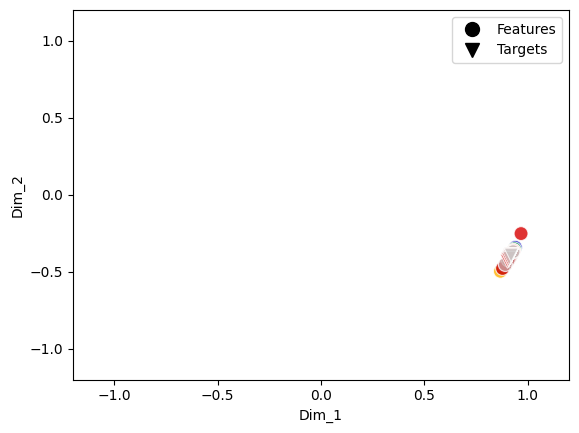

In [111]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])